In [1]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Module textproc nằm cùng thư mục với notebook
from textproc import (
    LABELS_5, normalize_text, maybe_segment, sentiment_prefix,
    approx_diacritic_ratio, restore_diacritics
)

ID2LBL = {i: l for i, l in enumerate(LABELS_5)}

# ==== Cấu hình cơ bản (sửa theo đường dẫn của bạn) ====
MODEL_DIR = "/home/dat/llm_ws/phobert/phobert_5cls_clean"  # đổi nếu cần

# 'cuda' nếu có GPU, không thì dùng 'cpu'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MAX_LEN = 160
USE_SEG = False          # bật nếu bạn train có segmentation
NORMALIZE = True
AUTO_RESTORE = True
RESTORE_THRESHOLD = 0.03
NEUTRAL_PENALTY = 0.0    # penalty cho 'neutral' (index 2)
USE_PREFIX = True        # bật để khớp lúc train
CPU_THREADS = 0          # 0 = mặc định PyTorch, >0 để giới hạn thread


/home/dat/llm_ws/.venv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ==== Load tokenizer + model ====
if DEVICE == "cuda" and not torch.cuda.is_available():
    raise RuntimeError("DEVICE được đặt là 'cuda' nhưng CUDA không khả dụng.")

device = torch.device(DEVICE)

if device.type == "cpu" and CPU_THREADS > 0:
    torch.set_num_threads(CPU_THREADS)

# Luôn nạp model float32, nếu chạy CPU thì ép map về CPU
load_kwargs = dict(torch_dtype=torch.float32, low_cpu_mem_usage=True)
if device.type == "cpu":
    load_kwargs["device_map"] = {"": "cpu"}

tok = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=False)
mdl = AutoModelForSequenceClassification.from_pretrained(
    MODEL_DIR, **load_kwargs
).to(device).eval()

print("Loaded model from:", MODEL_DIR)
print("Device:", device)
print("Labels:", LABELS_5)


`torch_dtype` is deprecated! Use `dtype` instead!
2025-11-16 02:33:34.810855: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 02:33:34.842233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-16 02:33:35.651090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Loaded model from: /home/dat/llm_ws/phobert/phobert_5cls_clean
Device: cuda
Labels: ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']


In [3]:
def softmax_np(x):
    x = x - np.max(x, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, keepdims=True)

def preprocess_text(raw: str) -> str:
    """Tiền xử lý giống script CLI."""
    s = normalize_text(raw) if NORMALIZE else raw

    # Auto restore dấu nếu tỷ lệ dấu < threshold
    if AUTO_RESTORE and approx_diacritic_ratio(s) < RESTORE_THRESHOLD:
        restored = restore_diacritics(s)
        print(f'[INFO] Auto-restore diacritics → "{restored}"')
        s = restored

    # Prefix cảm xúc (giống lúc train)
    if USE_PREFIX:
        s = sentiment_prefix(s, max_tag=1)

    # Word segmentation (nếu dùng)
    s = maybe_segment(s, use_seg=USE_SEG)
    return s

def predict_one(text: str):
    """Trả về (nhãn, độ tin cậy, vector xác suất)."""
    mdl.eval()
    s = preprocess_text(text)

    with torch.inference_mode():
        enc = tok([s], truncation=True, padding=True,
                  max_length=MAX_LEN, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = mdl(**enc).logits
        logits = logits.detach().cpu().numpy()[0]

    # (tuỳ chọn) chỉnh neutral
    if NEUTRAL_PENALTY != 0.0:
        logits[2] += NEUTRAL_PENALTY  # 'neutral' index 2

    probs = softmax_np(logits)
    pred_id = int(probs.argmax())
    pred_lbl = ID2LBL[pred_id]
    return pred_lbl, float(probs[pred_id]), probs

def pretty_print(text: str):
    pred_lbl, conf, probs = predict_one(text)
    print("=" * 60)
    print("Text:", text)
    print("Pred:", pred_lbl)
    print("Conf:", f"{conf:.6f}")
    print("Probs:")
    for i, name in enumerate(LABELS_5):
        print(f"  {name:15s}: {float(probs[i]):.6f}")


In [4]:
# ==== Test nhanh với một vài câu mẫu ====
samples = [
    "máy ảnh nét, màu sắc ổn định, rất ưng",
    "giao hàng chậm, sản phẩm trầy xước",
    "Mình thấy laptop bình thường",
    "Sản phẩm tạm ổn",
    "ok",
    "đồ ăn dở tệ, sẽ không mua lại"
]

for s in samples:
    pretty_print(s)


Text: máy ảnh nét, màu sắc ổn định, rất ưng
Pred: very_positive
Conf: 0.921808
Probs:
  very_negative  : 0.014576
  negative       : 0.011490
  neutral        : 0.012005
  positive       : 0.040122
  very_positive  : 0.921808
Text: giao hàng chậm, sản phẩm trầy xước
Pred: very_negative
Conf: 0.955151
Probs:
  very_negative  : 0.955151
  negative       : 0.012689
  neutral        : 0.013190
  positive       : 0.009461
  very_positive  : 0.009509
Text: Mình thấy laptop bình thường
Pred: neutral
Conf: 0.950480
Probs:
  very_negative  : 0.013415
  negative       : 0.013332
  neutral        : 0.950480
  positive       : 0.011699
  very_positive  : 0.011073
Text: Sản phẩm tạm ổn
Pred: neutral
Conf: 0.691361
Probs:
  very_negative  : 0.018567
  negative       : 0.031462
  neutral        : 0.691361
  positive       : 0.240247
  very_positive  : 0.018363
Text: ok
Pred: positive
Conf: 0.928326
Probs:
  very_negative  : 0.009965
  negative       : 0.009524
  neutral        : 0.024588
  positive  

In [5]:
# ==== Nhập tay để test ====
# Chạy cell này, sau đó gõ câu trên terminal Jupyter / VSCode.
# Bấm Enter rỗng để thoát.

# while True:
#     try:
#         text = input("Nhập câu (Enter rỗng để thoát): ").strip()
#     except EOFError:
#         break
#     if not text:
#         break
#     pretty_print(text)
    

In [6]:
import csv
from pathlib import Path

CSV_PATH = Path("/home/dat/llm_ws/data/test/test.csv")

def eval_on_csv(csv_path=CSV_PATH, max_rows=None):
    """
    Đọc file CSV có cột 'text' và 'label',
    chạy model và in ra dự đoán + tính accuracy.
    """
    golds = []
    preds = []

    with csv_path.open("r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            if max_rows is not None and i >= max_rows:
                break

            text = row["text"]
            gold = row["label"].strip()

            pred_lbl, conf, probs = predict_one(text)

            golds.append(gold)
            preds.append(pred_lbl)

            # In kết quả từng dòng (có thể bỏ bớt nếu quá dài)
            print("=" * 80)
            print(f"Row {i+1}")
            print("Text :", text)
            print("Gold :", gold)
            print("Pred :", pred_lbl)
            print("Conf :", f"{conf:.6f}")

    # Tính accuracy đơn giản
    correct = sum(g == p for g, p in zip(golds, preds))
    total = len(golds)
    acc = correct / total if total > 0 else 0.0

    print("\n" + "#" * 80)
    print(f"Done. Samples: {total}")
    print(f"Accuracy: {acc:.4f} ({correct}/{total})")

    # (tuỳ chọn) đếm theo từng label
    from collections import Counter
    print("\nGold label counts:", Counter(golds))
    print("Pred label counts:", Counter(preds))

# Gọi hàm để chạy trên toàn bộ file
eval_on_csv()

Row 1
Text : Thật bản thân thấy phí tiền mua luôn ấy . Mỏng mà n sát mồm với cái khẩu trang luôn á. Nchung k ăn thua . Đeo mà có lỡ đánh son chắc nhoe nhoét son ra lun ấy. Cân nhắc trk khi mua nhé mọi người
Gold : very_negative
Pred : very_positive
Conf : 0.786770
Row 2
Text : Shop làm ăn ko đúng giao hàng sai ko đúng như sản phẩm cần mua. Củ sạc 4 lỗ nhưng giao 2 lỗ. Mất uy tín
Gold : very_negative
Pred : very_negative
Conf : 0.845233
Row 3
Text : "3 viên vệ sinh máy, năm in trên bao bì là 2020, vì bất đồng ngôn ngữ nên ko rõ được ngày sản xuất hay ngày hết hạn. Nhưng bây giờ là 2022 rồi, nên thất vọng vì cách làm ăn của shop!"
Gold : very_negative
Pred : very_negative
Conf : 0.835262
Row 4
Text : Mình thấy dien thoai không đáng tiền, chất lượng chưa ổn.
Gold : very_negative
Pred : negative
Conf : 0.899767
Row 5
Text : Chất liệu:nỉ. Màu sắc:đen. Đúng với mô tả:ko nha. . Lúc đầu mình ko nghe được máy của ship per , lúc đấy rất buồn ạ . May mà shipper còn gọi r mới lấy được hàng , vì bả

[INFO] Auto-restore diacritics → ""nap nhua de van bulong thay doi khoang cach cua giá độ moi van vao de giu dien thoai. da bi rot ra nhu hình""
[INFO] Auto-restore diacritics → "“"
Accuracy: 0.8159  (430/527)

Classification report:
               precision    recall  f1-score   support

very_negative     0.9080    0.8655    0.8862       171
     negative     0.7500    0.7317    0.7407        82
      neutral     0.6933    0.7879    0.7376        66
     positive     0.6462    0.6774    0.6614        62
very_positive     0.8889    0.8767    0.8828       146

     accuracy                         0.8159       527
    macro avg     0.7773    0.7878    0.7817       527
 weighted avg     0.8204    0.8159    0.8176       527

Macro precision: 0.7773
Macro recall   : 0.7878
Macro F1       : 0.7817


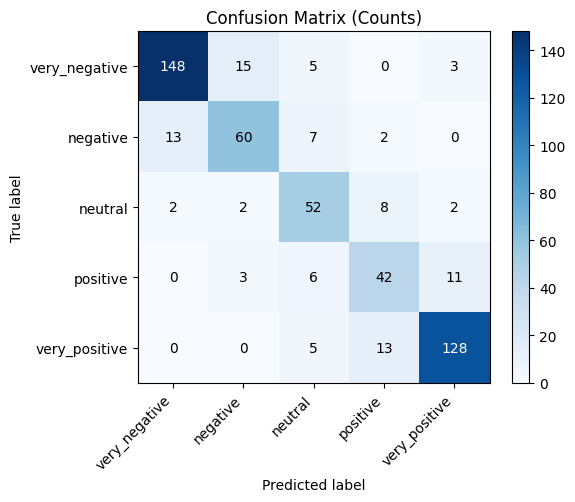

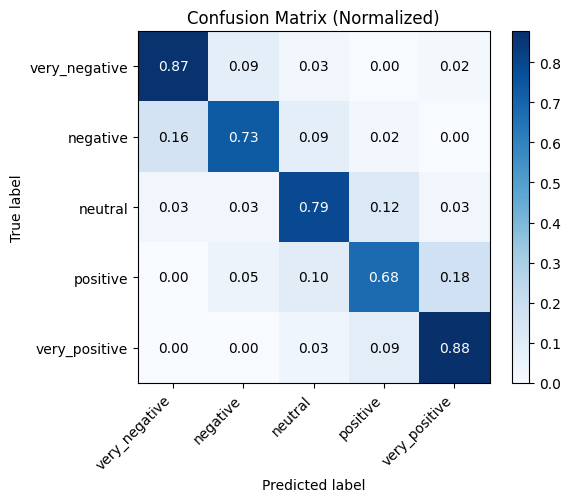

In [7]:
import csv
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

CSV_PATH = Path("/home/dat/llm_ws/data/test/test.csv")


def predict_dataset(csv_path=CSV_PATH, max_rows=None):
    """
    Đọc CSV (text,label), dùng predict_one() để dự đoán.
    Trả về: y_true, y_pred (danh sách label string).
    """
    y_true, y_pred = [], []

    with csv_path.open("r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            if max_rows is not None and i >= max_rows:
                break

            text = row["text"]
            gold = row["label"].strip()

            pred_lbl, conf, probs = predict_one(text)

            y_true.append(gold)
            y_pred.append(pred_lbl)

    return y_true, y_pred


# ==== Chạy dự đoán toàn bộ file ====
y_true, y_pred = predict_dataset()

# ==== Accuracy tổng ====
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}  ({sum(np.array(y_true) == np.array(y_pred))}/{len(y_true)})")

# ==== Precision, Recall, F1 (theo từng lớp + macro/weighted) ====
# Dùng đúng thứ tự LABELS_5 để khớp training
print("\nClassification report:")
print(
    classification_report(
        y_true,
        y_pred,
        labels=LABELS_5,
        target_names=LABELS_5,
        digits=4,
        zero_division=0,
    )
)

# Nếu bạn muốn lấy số liệu thô:
prec, rec, f1, support = precision_recall_fscore_support(
    y_true,
    y_pred,
    labels=LABELS_5,
    zero_division=0,
)
macro_prec = prec.mean()
macro_rec = rec.mean()
macro_f1 = f1.mean()

print("Macro precision:", f"{macro_prec:.4f}")
print("Macro recall   :", f"{macro_rec:.4f}")
print("Macro F1       :", f"{macro_f1:.4f}")

# ==== Confusion Matrix (đếm) ====
cm = confusion_matrix(y_true, y_pred, labels=LABELS_5)

fig, ax = plt.subplots(figsize=(6, 5))

# màu xanh nhẹ
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
plt.colorbar(im, ax=ax)

# Tick và label trục
ax.set_xticks(np.arange(len(LABELS_5)))
ax.set_yticks(np.arange(len(LABELS_5)))
ax.set_xticklabels(LABELS_5, rotation=45, ha="right")
ax.set_yticklabels(LABELS_5)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix (Counts)")

# In số lên từng ô, auto chọn màu chữ
max_val = cm.max() if cm.size > 0 else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        v = cm[i, j]
        text_color = "white" if v > max_val * 0.6 else "black"
        ax.text(j, i, v, ha="center", va="center", color=text_color)

plt.tight_layout()
plt.show()

# ==== Confusion Matrix (normalized theo hàng) ====
cm_norm = cm.astype("float")
row_sums = cm_norm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_norm, row_sums, out=np.zeros_like(cm_norm), where=row_sums != 0)

fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(cm_norm, interpolation="nearest", cmap="Blues")
plt.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(LABELS_5)))
ax.set_yticks(np.arange(len(LABELS_5)))
ax.set_xticklabels(LABELS_5, rotation=45, ha="right")
ax.set_yticklabels(LABELS_5)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix (Normalized)")

max_val_norm = cm_norm.max() if cm_norm.size > 0 else 0
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        v = cm_norm[i, j]
        text_color = "white" if v > max_val_norm * 0.6 else "black"
        ax.text(j, i, f"{v:.2f}", ha="center", va="center", color=text_color)

plt.tight_layout()
plt.show()


In [9]:
import time
import torch
from transformers import AutoModelForSequenceClassification

# Câu test cố định để đo thời gian
TEST_TEXT = "Mình thấy chất lượng sản phẩm bình thường, không tốt lắm cũng không tệ."

N = 500  # số lần lặp


# ================== ĐO THỜI GIAN TRÊN GPU (NẾU CÓ) ==================
if device.type == "cuda":
    # warm-up GPU với hàm predict_one hiện tại
    _ = predict_one(TEST_TEXT)
    torch.cuda.synchronize()

    t0 = time.time()
    for _ in range(N):
        _ = predict_one(TEST_TEXT)
    torch.cuda.synchronize()
    t1 = time.time()

    total_time_gpu = t1 - t0
    avg_time_gpu = total_time_gpu / N

    pred_lbl_gpu, conf_gpu, _ = predict_one(TEST_TEXT)

    print("===== GPU inference (predict_one hiện tại) =====")
    print("Text test      :", TEST_TEXT)
    print("Pred label     :", pred_lbl_gpu)
    print("Confidence     :", f"{conf_gpu:.4f}")
    print(f"Device         : {device}")
    print(f"Số lần lặp     : {N}")
    print(f"Tổng thời gian : {total_time_gpu:.4f} s")
    print(f"Thời gian 1 câu: {avg_time_gpu*1000:.2f} ms\n")
else:
    print("Không có GPU / device không phải 'cuda' → bỏ qua đo GPU.\n")


# ================== ĐO THỜI GIAN TRÊN CPU (MODEL RIÊNG) ==================
# Tạo model CPU riêng, không đụng vào model đang dùng cho predict_one
# device_cpu = torch.device("cpu")

# load_kwargs_cpu = dict(torch_dtype=torch.float32, low_cpu_mem_usage=True,
#                        device_map={"": "cpu"})
# mdl_cpu = AutoModelForSequenceClassification.from_pretrained(
#     MODEL_DIR,
#     **load_kwargs_cpu
# ).to(device_cpu).eval()

# def predict_one_cpu(text: str):
#     """Infer 1 câu trên CPU, dùng cùng pipeline preprocess như GPU."""
#     s = preprocess_text(text)

#     with torch.inference_mode():
#         enc = tok([s], truncation=True, padding=True,
#                   max_length=MAX_LEN, return_tensors="pt")
#         enc = {k: v.to(device_cpu) for k, v in enc.items()}
#         logits = mdl_cpu(**enc).logits
#         logits = logits.detach().cpu().numpy()[0]

#     if NEUTRAL_PENALTY != 0.0:
#         logits[2] += NEUTRAL_PENALTY  # 'neutral' index 2

#     probs = softmax_np(logits)
#     pred_id = int(probs.argmax())
#     pred_lbl = ID2LBL[pred_id]
#     return pred_lbl, float(probs[pred_id]), probs

# # warm-up CPU
# _ = predict_one_cpu(TEST_TEXT)

# t0 = time.time()
# for _ in range(N):
#     _ = predict_one_cpu(TEST_TEXT)
# t1 = time.time()

# total_time_cpu = t1 - t0
# avg_time_cpu = total_time_cpu / N

# pred_lbl_cpu, conf_cpu, _ = predict_one_cpu(TEST_TEXT)

# print("===== CPU inference (model riêng trên CPU) =====")
# print("Text test      :", TEST_TEXT)
# print("Pred label     :", pred_lbl_cpu)
# print("Confidence     :", f"{conf_cpu:.4f}")
# print(f"Device         : {device_cpu}")
# print(f"Số lần lặp     : {N}")
# print(f"Tổng thời gian : {total_time_cpu:.4f} s")
# print(f"Thời gian 1 câu: {avg_time_cpu*1000:.2f} ms")


===== GPU inference (predict_one hiện tại) =====
Text test      : Mình thấy chất lượng sản phẩm bình thường, không tốt lắm cũng không tệ.
Pred label     : neutral
Confidence     : 0.9454
Device         : cuda
Số lần lặp     : 500
Tổng thời gian : 2.1736 s
Thời gian 1 câu: 4.35 ms

